#**Deep Learning in Python Project: Data Augmentation**

# Libraries

In [63]:
#pip install tensorflow_addons (install if needed)
import os
import cv2
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from random import randint


# Opening and Displaying Images

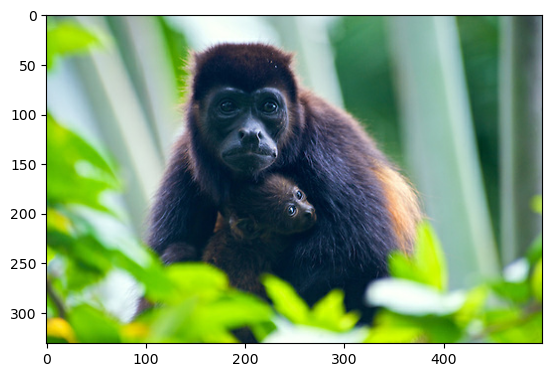

In [16]:
img_path = "drive/MyDrive/DLIP/Images/city.jpg"
img_path = "./data/train/normal_train_data/monkey/n017.jpg"

my_img = tf.io.read_file(img_path)
tensor = tf.io.decode_image(my_img, channels=3, dtype=tf.dtypes.float32)
plt.imshow(tensor)
normal_tensor = tensor
plt.savefig("./results/monkey_normal.png")

# Gaussian Blur


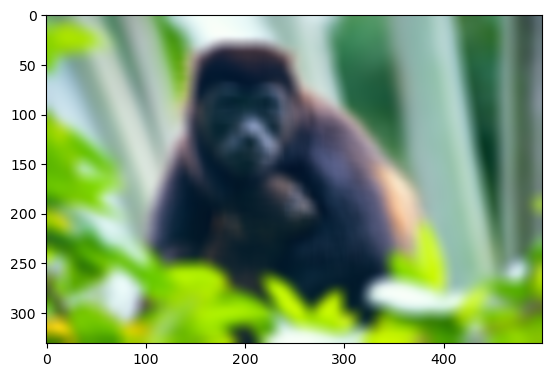

In [17]:
my_img = tf.io.read_file(img_path)
tensor = tf.io.decode_image(my_img, channels=3, dtype=tf.dtypes.float32)
img_blur = tfa.image.gaussian_filter2d(tensor, filter_shape = (15,15), sigma = 30.5)
plt.imshow(img_blur)
gblur_tensor = tensor
plt.savefig("./results/monkey_gblur.png")

# Gaussian Noise


In [7]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
    elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
    elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
    elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


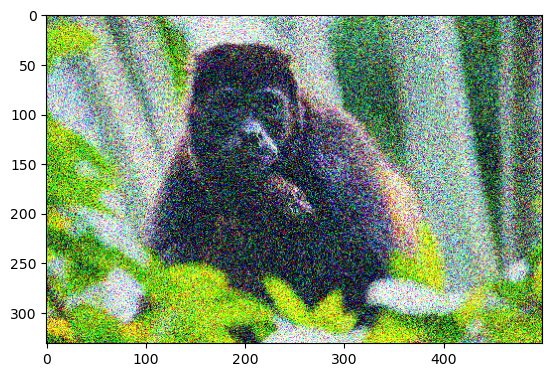

In [18]:
my_img = tf.io.read_file(img_path)
tensor = tf.io.decode_image(my_img, channels=3, dtype=tf.dtypes.float32)
img_noise = noisy("gauss", tensor)
plt.imshow(img_noise)
gnoise_tensor = tensor
plt.savefig("./results/monkey_gnoise.png")

# Exposure

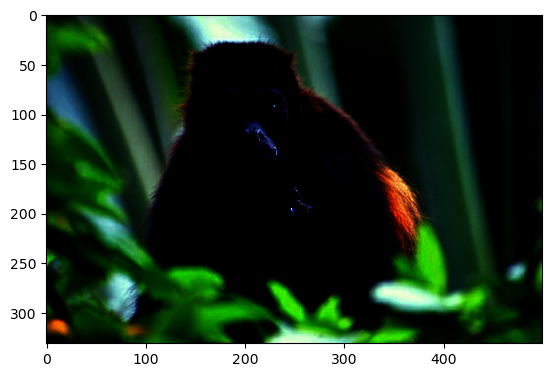

In [19]:
# Underexposed Image
my_img = tf.io.read_file(img_path)
tensor = tf.io.decode_image(my_img, channels=3, dtype=tf.dtypes.float32)
img_under = tf.image.adjust_gamma(tensor, gamma = 8)
plt.imshow(img_under)
under_tensor = tensor
plt.savefig("./results/monkey_under.png")

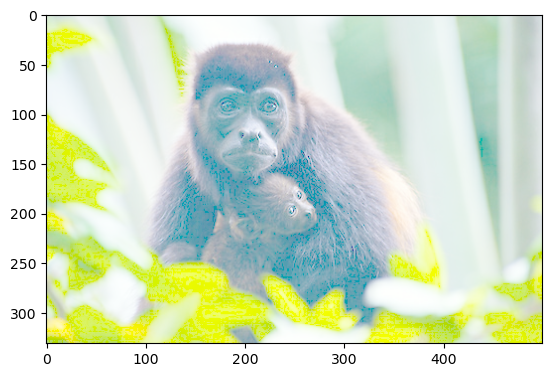

In [20]:
# Overexposed Image
my_img = tf.io.read_file(img_path)
tensor = tf.io.decode_image(my_img, channels=3, dtype=tf.dtypes.float32)
img_over = tf.image.adjust_gamma(tensor, gamma = 0.2)
plt.imshow(img_over)
over_tensor = tensor
plt.savefig("./results/monkey_over.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


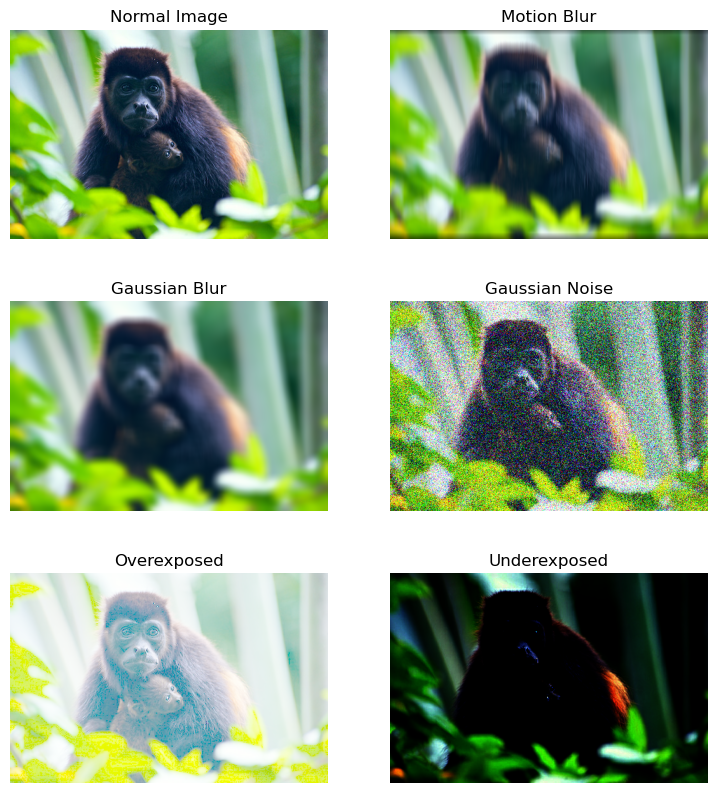

In [82]:
fig, ax = plt.subplots(3,2, figsize=(9,10))
ax[0,0].imshow(normal_tensor)
ax[0,0].set_title("Normal Image")
ax[0,0].axis("off")
ax[0,1].imshow(img_motion.numpy().squeeze())
ax[0,1].set_title("Motion Blur")
ax[0,1].axis("off")

ax[1,0].imshow(img_blur)
ax[1,0].set_title("Gaussian Blur")
ax[1,0].axis("off")
ax[1,1].imshow(img_noise)
ax[1,1].set_title("Gaussian Noise")
ax[1,1].axis("off")

ax[2,0].imshow(img_over)
ax[2,0].set_title("Overexposed")
ax[2,0].axis("off")
ax[2,1].imshow(img_under)
ax[2,1].set_title("Underexposed")
ax[2,1].axis("off")

fig.savefig("./results/augmentations.png", bbox_inches="tight")


# Motion Blur

### Horizontal

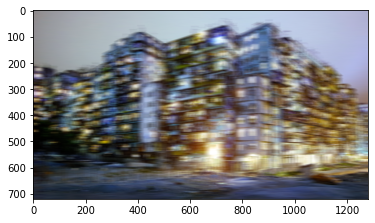

In [ ]:
img = cv2.imread(img_path)
  
# Specify the kernel size.
# The greater the size, the more the motion.
kernel_size = 30
  
# Create the horizontal kernel.
kernel_h = np.copy(kernel_v)
  
# Fill the middle row with ones.
kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
  
# Normalize.
kernel_h /= kernel_size
    
# Apply the horizontal kernel.
img_hmb = cv2.filter2D(img, -1, kernel_h)

plt.imshow(img_hmb)

### Vertical

In [76]:
class MotionBlur(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MotionBlur, self).__init__(**kwargs)
        
    def call(self, images, training=None):
        if not training:
            return images
        strength = 20 
        direction = randint(0, 1)
        if direction == 0: # 0 is horizontal, 1 is vertical
            kernel = np.zeros([3,strength]) 
            kernel[1] = 1/strength                                                                                                                                    
        else:
            kernel = np.zeros([strength,3]) 
            kernel[:,1] = 1/strength   
        kernel_motion_blur = tf.convert_to_tensor(kernel, tf.float32)
        kernel_motion_blur = tf.tile(kernel_motion_blur[..., None, None], [1,1,3,1])
        images = tf.nn.depthwise_conv2d(images, kernel_motion_blur, strides=(1,1,1,1), padding='SAME')
        return images

layer = MotionBlur()

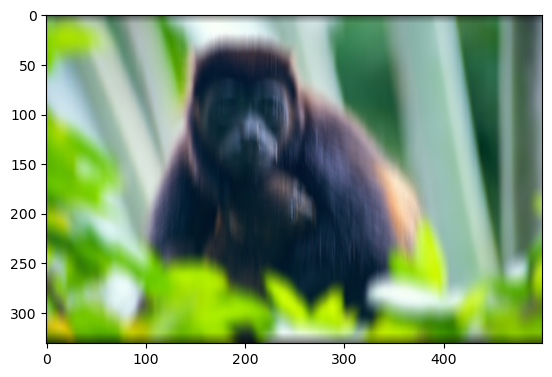

In [77]:

img_motion = tf.expand_dims(tensor, axis=0)
img_motion = layer(img_motion, training=True)
plt.imshow(img_motion.numpy().squeeze())

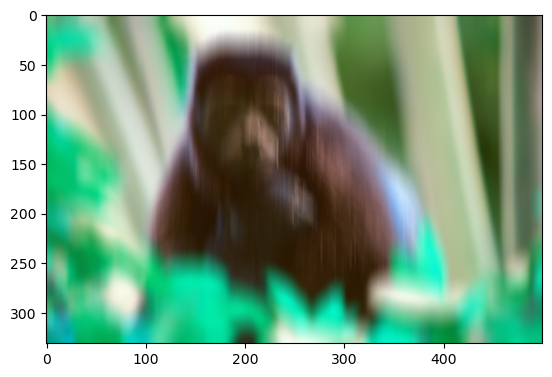

In [56]:
img = cv2.imread(img_path)

# Specify the kernel size.
# The greater the size, the more the motion.
kernel_size = 30
  
# Create the vertical kernel.
kernel_v = np.zeros((kernel_size, kernel_size))
  
# Fill the middle row with ones.
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
  
# Normalize.
kernel_v /= kernel_size
  
# Apply the vertical kernel.
img_vmb = cv2.filter2D(img, -1, kernel_v)

plt.imshow(img_vmb)

# JPEG Compression

